In [46]:
from bs4 import BeautifulSoup
from collections import Counter
import nltk 
from nltk.corpus import stopwords
import os
import pandas as pd
import numpy as np
import string
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import	TfidfVectorizer
import time
from random import seed, sample
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import tqdm

seed(26)

warnings.filterwarnings("ignore")

nltk.download('stopwords')

sns.set_palette('gray')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path_train = "../data/training"
path_test = "../data/test"

# Read files

In [3]:
def read_files(main_path:str)->pd.DataFrame:

    path_list = []
    file_list = []
    content_list = []

    for path in os.listdir(main_path):
        _path = os.path.join(main_path, path)
        if os.path.isdir(_path):
            for file in os.listdir(_path):
                _file = os.path.join(_path, file)
                if os.path.isfile(_file):
                    with open(_file, 'r',  errors='ignore') as f:
                        content = f.read()
                    path_list.append(path)
                    file_list.append(file)
                    content_list.append(content)

    return pd.DataFrame( { 'number_file': file_list, 'target': path_list,  'content': content_list})

In [4]:
df_train = read_files(path_train)
df_train = df_train.astype({'number_file': int, 'content':str})
df_train.head()

,number_file,target,content
0,5,acq,\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...
1,7,acq,\n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...
2,27,acq,\n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...
3,28,acq,\n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...
4,44,acq,\n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...


In [5]:
df_test = read_files(path_test)
df_test = df_test.astype({'number_file': int, 'content':str})
df_test.head()

,number_file,target,content
0,9613,acq,\n\nSUMITOMO BANK AIMS AT QUICK RECOVERY FROM ...
1,9618,acq,\n\nBOND CORP STILL CONSIDERING ATLAS MINING B...
2,9628,acq,\n\nCRA SOLD FORREST GOLD FOR 76 MLN DLRS - WH...
3,9643,acq,\n\nANHEUSER-BUSCH JOINS BID FOR SAN MIGUEL\n\...
4,9653,acq,\n\nMONIER SAYS BRITAIN'S REDLAND MAY BID FOR ...


In [6]:
print(df_train.shape, df_train.target.nunique())
print(df_test.shape, df_test.target.nunique())

(11413, 3) 91
(4024, 3) 91


In [7]:
count_target = df_test.target.value_counts().reset_index(name='count')
count_target

,target,count
0,earn,1087
1,acq,719
2,unknown,280
3,crude,189
4,money-fx,179
...,...,...
86,castor-oil,1
87,groundnut-oil,1
88,instal-debt,1
89,palladium,1


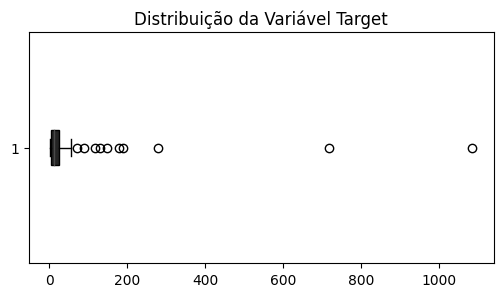

In [8]:
sns.set_palette("gray")
plt.figure(figsize=(6, 3))
plt.boxplot(x=count_target['count'], vert=False, patch_artist=True)
plt.title('Distribuição da Variável Target')
plt.show()

In [9]:
q1 = np.percentile(count_target['count'], 25)
q3 = np.percentile(count_target['count'], 75)
iqr = q3 - q1
q1, q3, iqr

(3.0, 26.0, 23.0)

In [10]:
count_target.query("count < 5").shape, count_target.query("count < 67").shape
# vou cortar lá em baixo depois dos enconddings

((31, 2), (81, 2))

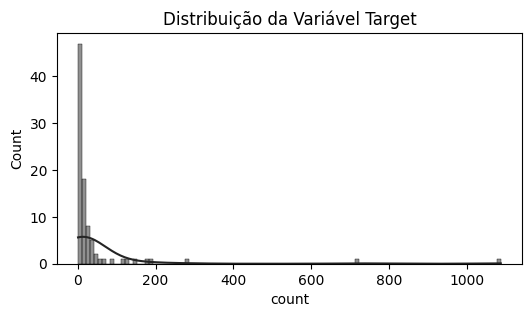

In [11]:
sns.set_palette("gray")
plt.figure(figsize=(6, 3))
sns.histplot(count_target['count'], kde=True) 
plt.title('Distribuição da Variável Target')
plt.show()

# Preprocessing


In this case we will use 2 approaches to represent these documents, TF-IDF and SBERT, therefore, using TF-IDF we will use the following preprocessing:

    - [] convert text to lowercase letters
    - [] removing numbers
    - [] removing symbols
    - [] removing tags (HTML/XML)
    - [] removing urls
    - [] removing stop words
    
To generate these embeddings using Language Models, we will not use any preprocessing and wait for the model to make the best decision.

In [12]:
pp_config = { 'convert': 'lower', 
              'numbers': True,
              'split_line':True,
              'stop_words': True,     
              'symbols':True,       
              'tags': True,
              'url': True,
            }

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text:str):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_html(text):
    return BeautifulSoup(text, "html").text

def remove_split_line(text:str):
    return re.sub(r'[\n\t]', '', text)

def remove_numbers(text):
    return re.sub(r'\d', '', text)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess_english_text(text:str, config:dict):

    if config['convert'] == 'lower':
        text = text.lower()
    if config['numbers'] == True:
        text = remove_numbers(text)
    if config['split_line'] == True:
        text = remove_split_line(text)
    if config['stop_words'] == True:   
        text = remove_stopwords(text)
    if config['symbols'] == True:
        text = remove_punctuation(text)
    if config['tags'] == True:
        text = remove_html(text)
    if config['url'] == True:
        text = remove_urls(text)
    
    return text

def count_words(values:np.array):
    
    cnt = Counter()
    for text in values:
        for word in text.split():
            cnt[word] += 1
    return cnt

In [13]:
start_time = time.time()
df_train['processed'] = df_train['content'].apply( lambda x : preprocess_english_text(x, pp_config) )
df_test['processed'] = df_train['content'].apply( lambda x : preprocess_english_text(x, pp_config) )
print(f"Finish time to preprocessing the text: {time.time() - start_time}")

cnt = count_words(df_train["processed"].values)
RAREWORDS = set([w for w, w_count in cnt.items() if w_count == 1])
COMMONWORDS = set([w for (w, w_count) in cnt.most_common()[:10]])

df_train['processed2'] = df_train['processed'].apply( lambda x : ' '.join([word for word in x.split() if word not in RAREWORDS]))
df_train['processed2'] = df_train['processed'].apply( lambda x : ' '.join([word for word in x.split() if word not in COMMONWORDS]))

df_test['processed2'] = df_test['processed'].apply( lambda x : ' '.join([word for word in x.split() if word not in RAREWORDS]))
df_test['processed2'] = df_test['processed'].apply( lambda x : ' '.join([word for word in x.split() if word not in COMMONWORDS]))

Finish time to preprocessing the text: 6.158733129501343


# Encoding

In [14]:
# Here we define a max features equals 384 to keep the same size of sbert
def tf_idf_technicals(train:pd.DataFrame, test:pd.DataFrame, type:str):

    initial_time = time.time()
    
    if type == 'tf':
        vectorizer = TfidfVectorizer(use_idf=False, norm='l1', max_features=384) 
    elif type == 'idf':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm='l2', max_features=384)  
    elif type == 'tf-idf':
        vectorizer = TfidfVectorizer(max_features=384)

    matrix = vectorizer.fit_transform(train)
    vector = vectorizer.transform(test)

    words = vectorizer.get_feature_names_out()

    tfidf_train = pd.DataFrame(data=matrix.toarray(), columns=words)
    tfidf_test = pd.DataFrame(data=vector.toarray(), columns=words)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(words)}")
    return tfidf_train, tfidf_test

def get_embeddings(model_name:str, data):
    
    initial_time = time.time()

    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(data)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(sentence_embeddings)}")
    return sentence_embeddings

In [15]:
tfidf_train, tfidf_test = tf_idf_technicals(df_train['processed'], df_test['processed'], 'tf-idf')

Execution time: 1.416076421737671s
Size:384


In [16]:
model_name= 'paraphrase-MiniLM-L6-v2'
print("Embeddings Train")
sentence_train = get_embeddings(model_name, df_train['content'])

print("Embeddings Test")
sentence_test= get_embeddings(model_name, df_test['content'])

Embeddings Train
Execution time: 357.211101770401s
Size:11413
Embeddings Test
Execution time: 116.57050585746765s
Size:4024


## Save embeddings preprocessed

In [17]:
df_train_result = pd.concat([tfidf_train, df_train[['number_file', 'target']]], axis=1)
df_train_result.to_csv('../data/tfidf_train.csv', index=False)
df_test_result = pd.concat([tfidf_test, df_test[['number_file', 'target']]], axis=1)
df_test_result.to_csv('../data/tfidf_test.csv', index=False)

np.save('../data/embeddings_train.npy', sentence_train)
np.save('../data/embeddings_test.npy', sentence_test)

# Loading preprocessed data

In [18]:
sentence_train = np.load('../data/embeddings_train.npy')
sentence_test = np.load('../data/embeddings_test.npy')

tfidf_train = pd.read_csv("../data/tfidf_train.csv")
tfidf_test = pd.read_csv("../data/tfidf_test.csv")

# Machine Learning

## Imports

In [19]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, make_scorer

## Parameters

In [43]:
param_grid_naive_bayes = {
    'alpha': [0.1, 1.0, 2.0],
    'fit_prior': [True, False]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}


svm_classifier = SVC()
naive_bayes_classifier = MultinomialNB()
knn_classifier = KNeighborsClassifier()

classifiers = {
    'Naive Bayes': (naive_bayes_classifier, param_grid_naive_bayes),
    'KNN': (knn_classifier, param_grid_knn),
    'SVM': (svm_classifier, param_grid_svm),
}

## Functions

In [44]:
def apply_grid_search(X, y, param_grid, classifier):

    f1_scorer_macro = make_scorer(f1_score, average='macro')

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=10, scoring=f1_scorer_macro, verbose=2, n_jobs=-1)

    with tqdm(total=len(param_grid)) as pbar:
        def update_pbar(_):
            pbar.update(1)

        grid_search.n_iter = update_pbar
        grid_search.fit(X, y)

    best_classifier = grid_search.best_estimator_
    
    return best_classifier

def format_classification_report_with_count_class(y_true, y_pred, class_report):
    
    df_class_report = pd.DataFrame(class_report).T

    count_train = y_true.value_counts().reset_index()
    count_train.columns = ['target', 'count_true']

    count_pred = pd.Series(y_pred).value_counts().reset_index()
    count_pred.columns = ['target', 'count_pred']

    df_class_report = df_class_report.join(count_train.set_index('target'), on=df_class_report.index)
    df_class_report = df_class_report.join(count_pred.set_index('target'), on=df_class_report.index)

    # Adicione os nomes das classes a partir do class_report
    df_class_report['target_names'] = df_class_report.index

    return df_class_report

def calculate_metrics(y_true, y_pred):
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_report = format_classification_report_with_count_class(y_true, y_pred, class_report)

    return {'macro-f1': macro_f1, 'accuracy': accuracy, 'precision': precision, 'recall': recall}, class_report

def create_metrics_dataframe(clf_name, e_name, execution_time, result_metrics, best_classifier):
    metrics_df = pd.DataFrame({
        'classifier': clf_name,
        'embedding': e_name,
        'execution_time': execution_time,
        'f1': result_metrics[0]['macro-f1'],
        'accuracy': result_metrics[0]['accuracy'],
        'precision': result_metrics[0]['precision'],
        'recall': result_metrics[0]['recall'],
        'param': [best_classifier.get_params()]
    })
    return metrics_df

## ML. "Main"

In [45]:
data_train = [np.abs(sentence_train), tfidf_train.drop(columns=['target', 'number_file']).values]
data_test = [np.abs(sentence_test), tfidf_test.drop(columns=['target', 'number_file']).values]

target_train = tfidf_train['target']
target_test = tfidf_test['target']

training_info_df = pd.DataFrame(columns=['classifier', 'embedding', 'execution_time', 'f1', 'accuracy', 'precision', 'recall', 'param'])
testing_info_df = pd.DataFrame(columns=['classifier', 'embedding', 'execution_time', 'f1', 'accuracy', 'precision', 'recall', 'param'])

report_df = pd.DataFrame()

for train, test, e_name in zip(data_train, data_test, ['sentence-bert', 'tf-idf']):

    print(f"Grid from {e_name}:")

    for clf_name, (classifier, param_grid) in tqdm(classifiers.items()):
        print(clf_name)
        start_time = time.time()
        best_classifier = apply_grid_search(train, target_train, param_grid, classifier)
        end_time = time.time()
        execution_time = end_time - start_time

        y_train_pred = best_classifier.predict(train)
        result_metrics_train = calculate_metrics(target_train, y_train_pred)

        temp_df_train = create_metrics_dataframe(clf_name, e_name, execution_time, result_metrics_train, best_classifier)
        training_info_df = pd.concat([training_info_df, temp_df_train], ignore_index=True)

        y_test_pred = best_classifier.predict(test)
        result_metrics_test = calculate_metrics(target_test, y_test_pred)

        temp_df_test = create_metrics_dataframe(clf_name, e_name, execution_time, result_metrics_test, best_classifier)
        testing_info_df = pd.concat([testing_info_df, temp_df_test], ignore_index=True)

        result_metrics_train[1]['classifier'] = clf_name
        result_metrics_train[1]['dataset'] = 'treinamento'
        report_df = pd.concat([report_df, result_metrics_train[1]], ignore_index=True)

        result_metrics_test[1]['classifier'] = clf_name
        result_metrics_test[1]['dataset'] = 'teste'
        report_df = pd.concat([report_df, result_metrics_test[1]], ignore_index=True)

report_df.to_csv("../data/report_df.csv", index=False)
training_info_df.to_csv("../data/training_info.csv", index=False)
testing_info_df.to_csv("../data/testing_info.csv", index=False)
#107 min

Grid from sentence-bert:


  0%|          | 0/3 [00:00<?, ?it/s]

Naive Bayes


Fitting 10 folds for each of 6 candidates, totalling 60 fits


 33%|███▎      | 1/3 [00:04<00:08,  4.06s/it]

KNN


Fitting 10 folds for each of 24 candidates, totalling 240 fits


 67%|██████▋   | 2/3 [08:25<04:56, 296.41s/it]

SVM


Fitting 10 folds for each of 9 candidates, totalling 90 fits


100%|██████████| 3/3 [49:15<00:00, 985.03s/it] 


Grid from tf-idf:


  0%|          | 0/3 [00:00<?, ?it/s]

Naive Bayes


Fitting 10 folds for each of 6 candidates, totalling 60 fits


 33%|███▎      | 1/3 [00:03<00:06,  3.20s/it]

KNN


Fitting 10 folds for each of 24 candidates, totalling 240 fits


 67%|██████▋   | 2/3 [04:57<02:54, 174.16s/it]

SVM


Fitting 10 folds for each of 9 candidates, totalling 90 fits


100%|██████████| 3/3 [56:00<00:00, 1120.02s/it]


# Results Analisys

In [2]:
report = pd.read_csv("../data/report_df.csv")
training = pd.read_csv("../data/training_info.csv")
testing = pd.read_csv("../data/testing_info.csv")

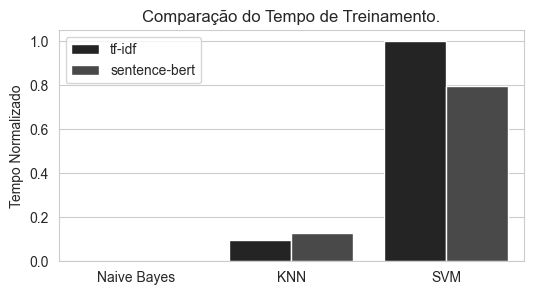

In [43]:
aux_graph = training.groupby(["classifier", "embedding"])['execution_time'].mean().reset_index()
minimo = aux_graph['execution_time'].min()
maximo = aux_graph['execution_time'].max()
aux_graph['time_normalized'] = (aux_graph['execution_time'] - minimo) / (maximo - minimo)
aux_graph = aux_graph.sort_values(by='time_normalized')

plt.figure(figsize=(6, 3))
ax = sns.barplot(x="classifier", y="time_normalized", hue="embedding", data=aux_graph, ci=None)
ax.set_title('Comparação do Tempo de Treinamento.')
ax.legend(loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('Tempo Normalizado')

plt.show()

In [30]:
aux_graph

,classifier,embedding,execution_time,time_normalized
3,Naive Bayes,tf-idf,2.609436,0.000000
2,Naive Bayes,sentence-bert,3.305379,0.000230
1,KNN,tf-idf,290.852264,0.095328
0,KNN,sentence-bert,393.076175,0.129135
4,SVM,sentence-bert,2404.948440,0.794501
5,SVM,tf-idf,3026.318996,1.000000


In [14]:
asb = training.sort_values(by='f1', ascending=False).query("embedding == 'sentence-bert'")
atf = training.sort_values(by='f1', ascending=False).query("embedding == 'tf-idf'")
aux_graph = pd.concat([asb, atf], axis=0)
aux_graph

,classifier,embedding,execution_time,f1,accuracy,precision,recall,param
0,Naive Bayes,sentence-bert,3.305379,0.514049,0.654429,0.456512,0.724884,"{'alpha': 0.1, 'class_prior': None, 'fit_prior..."
2,SVM,sentence-bert,2404.948440,0.457325,0.812407,0.547430,0.431200,"{'C': 1, 'break_ties': False, 'cache_size': 20..."
1,KNN,sentence-bert,393.076175,0.400595,0.768071,0.483918,0.387373,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm..."
5,SVM,tf-idf,3026.318996,0.455142,0.818277,0.532137,0.434357,"{'C': 10, 'break_ties': False, 'cache_size': 2..."
3,Naive Bayes,tf-idf,2.609436,0.393936,0.662140,0.349091,0.638552,"{'alpha': 0.1, 'class_prior': None, 'fit_prior..."
4,KNN,tf-idf,290.852264,0.298215,0.739157,0.381453,0.304045,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


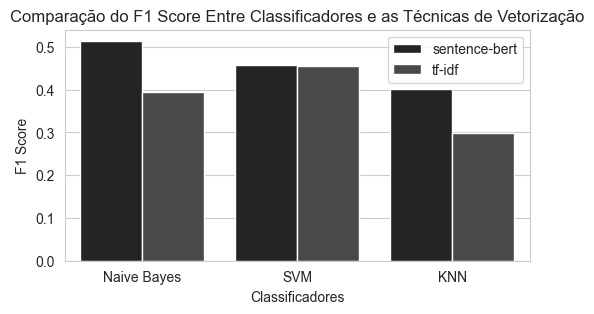

In [50]:
aux_graph = training.sort_values(by='f1', ascending=False).drop_duplicates()
plt.figure(figsize=(6, 3))
ax = sns.barplot(x="classifier", y="f1", hue="embedding", data=aux_graph, ci=None)
ax.set_title('Comparação do F1 Score Entre Classificadores e as Técnicas de Vetorização')
ax.legend(loc='upper right')
ax.set_xlabel('Classificadores')
ax.set_ylabel('F1 Score')
plt.show()

In [55]:
# f1 treino x teste por classifier
testing['type'] = 'test'
training['type'] = 'train'
result = pd.concat([training, testing], axis=0)
result

,classifier,embedding,execution_time,f1,accuracy,precision,recall,param,type
0,Naive Bayes,sentence-bert,3.305379,0.514049,0.654429,0.456512,0.724884,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",train
1,KNN,sentence-bert,393.076175,0.400595,0.768071,0.483918,0.387373,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",train
2,SVM,sentence-bert,2404.948440,0.457325,0.812407,0.547430,0.431200,"{'C': 1, 'break_ties': False, 'cache_size': 20...",train
3,Naive Bayes,tf-idf,2.609436,0.393936,0.662140,0.349091,0.638552,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",train
4,KNN,tf-idf,290.852264,0.298215,0.739157,0.381453,0.304045,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",train
5,SVM,tf-idf,3026.318996,0.455142,0.818277,0.532137,0.434357,"{'C': 10, 'break_ties': False, 'cache_size': 2...",train
0,Naive Bayes,sentence-bert,3.305379,0.348682,0.652833,0.364981,0.379840,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",test
1,KNN,sentence-bert,393.076175,0.288586,0.657803,0.350193,0.281707,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",test
2,SVM,sentence-bert,2404.948440,0.286930,0.672465,0.369435,0.263874,"{'C': 1, 'break_ties': False, 'cache_size': 20...",test
3,Naive Bayes,tf-idf,2.609436,0.008638,0.151093,0.007500,0.011887,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",test


In [57]:
result['execution_time'] = result['execution_time'] / 60 
result.query('type == "test"')

,classifier,embedding,execution_time,f1,accuracy,precision,recall,param,type
0,Naive Bayes,sentence-bert,0.055090,0.348682,0.652833,0.364981,0.379840,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",test
1,KNN,sentence-bert,6.551270,0.288586,0.657803,0.350193,0.281707,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",test
2,SVM,sentence-bert,40.082474,0.286930,0.672465,0.369435,0.263874,"{'C': 1, 'break_ties': False, 'cache_size': 20...",test
3,Naive Bayes,tf-idf,0.043491,0.008638,0.151093,0.007500,0.011887,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",test
4,KNN,tf-idf,4.847538,0.010258,0.175944,0.012693,0.013012,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",test
5,SVM,tf-idf,50.438650,0.012131,0.192097,0.011680,0.015410,"{'C': 10, 'break_ties': False, 'cache_size': 2...",test


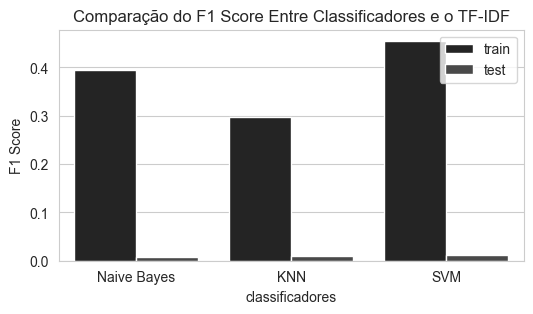

In [53]:
aux = result.query("embedding == 'tf-idf'")
plt.figure(figsize=(6, 3))
ax = sns.barplot(x="classifier", y="f1", hue="type", data=aux, ci=None)
ax.set_title('Comparação do F1 Score Entre Classificadores e o TF-IDF')
ax.legend(loc='upper right')
ax.set_xlabel('classificadores')
ax.set_ylabel('F1 Score')
plt.show()

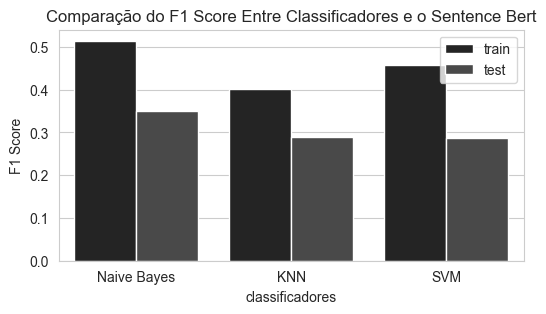

In [52]:
aux = result.query("embedding == 'sentence-bert'")
plt.figure(figsize=(6, 3))
ax = sns.barplot(x="classifier", y="f1", hue="type", data=aux, ci=None)
ax.set_title('Comparação do F1 Score Entre Classificadores e o Sentence Bert')
ax.legend(loc='upper right')
ax.set_xlabel('classificadores')
ax.set_ylabel('F1 Score')
plt.show()

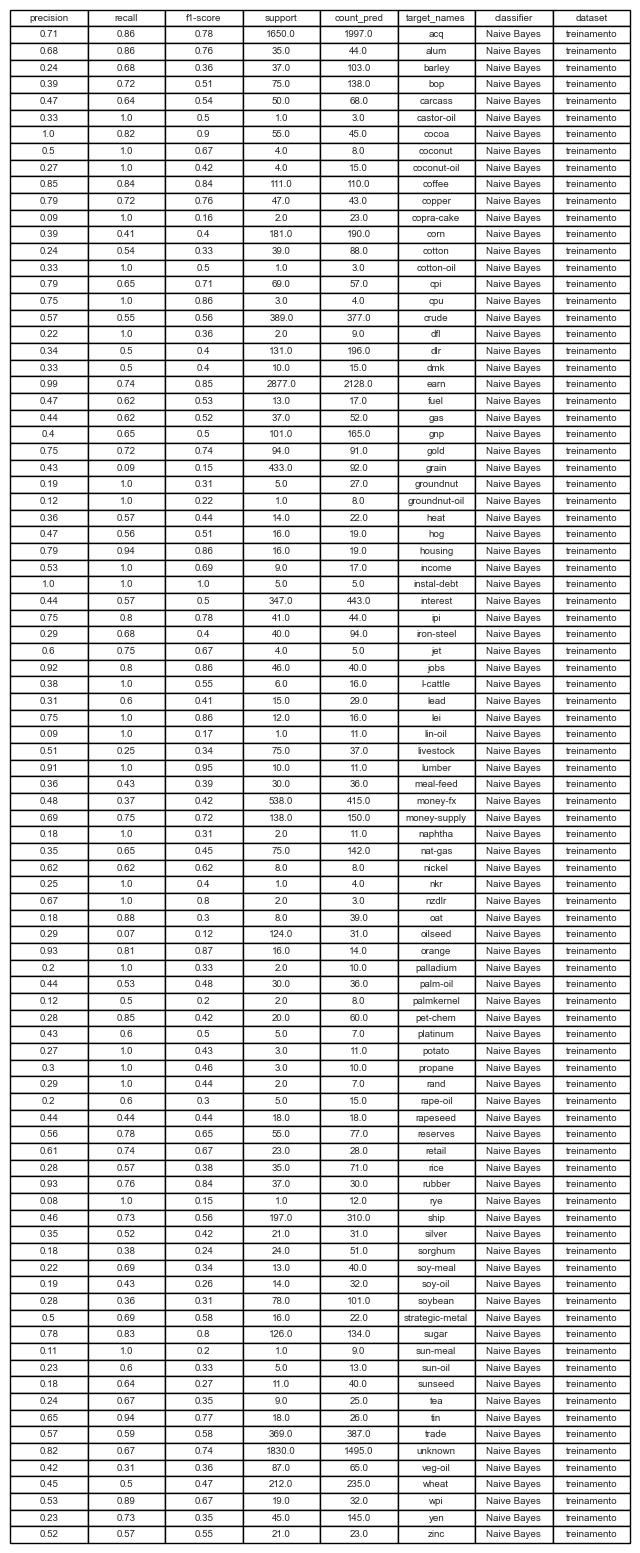

In [43]:
aux = report.query("classifier == 'Naive Bayes' and dataset == 'treinamento'").head(91).drop(columns='count_true')
aux = aux.round(decimals=2)

fig, ax = plt.subplots(figsize=(8, 4)) 
ax.axis('tight')
ax.axis('off')
ax.table(cellText=aux.values, colLabels=aux.columns, cellLoc='center', loc='center')

# Salvar a figura em PDF
plt.savefig('metrics_by_class_train_naive.pdf', format='pdf', bbox_inches='tight')

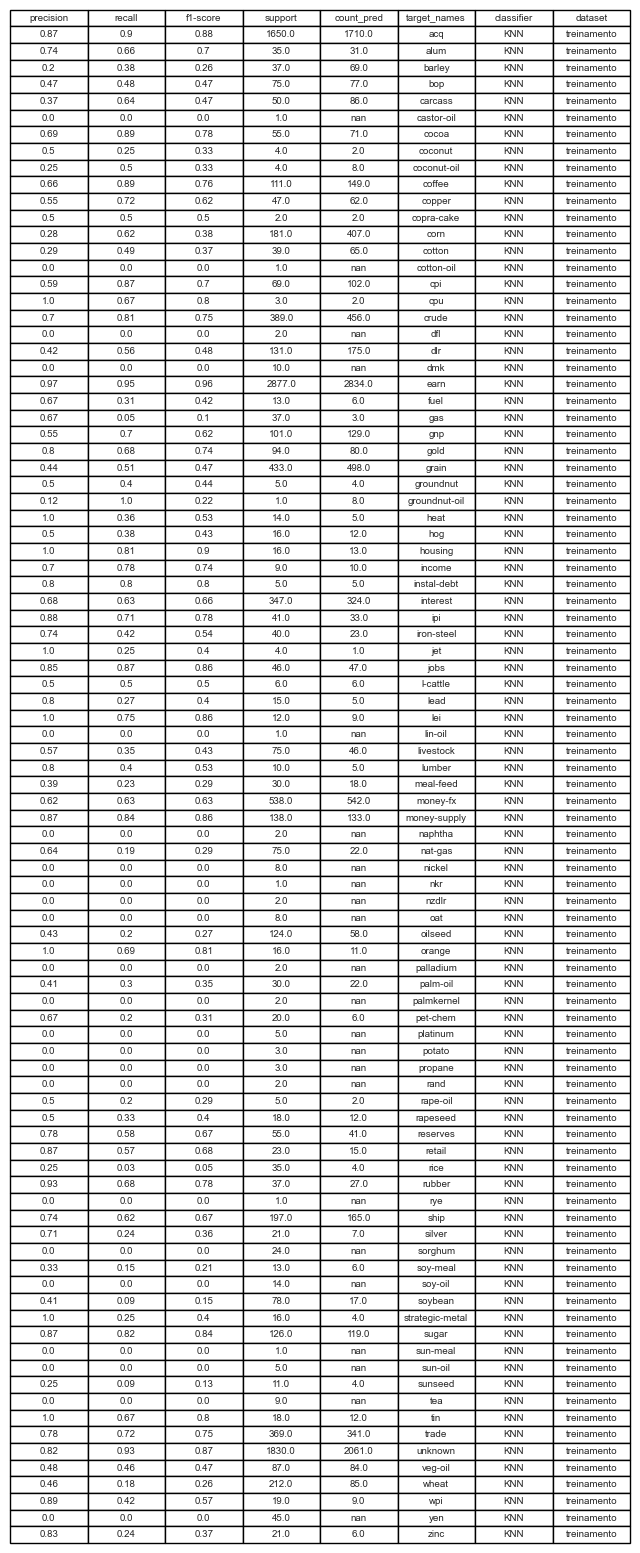

In [44]:
aux = report.query("classifier == 'KNN' and dataset == 'treinamento'").head(91).drop(columns='count_true')

aux = aux.round(decimals=2)

fig, ax = plt.subplots(figsize=(8, 4)) 
ax.axis('tight')
ax.axis('off')
ax.table(cellText=aux.values, colLabels=aux.columns, cellLoc='center', loc='center')

# Salvar a figura em PDF
plt.savefig('metrics_by_class_train_knn.pdf', format='pdf', bbox_inches='tight')

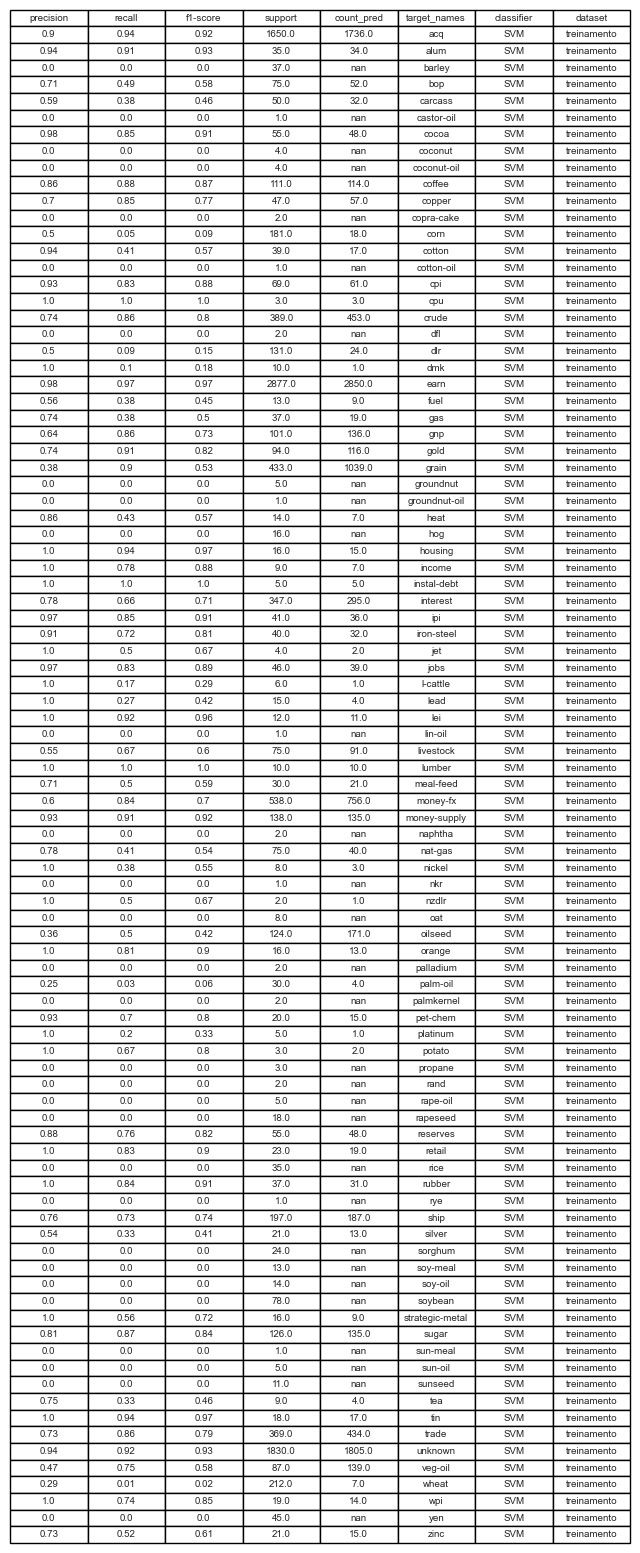

In [45]:
aux = report.query("classifier == 'SVM' and dataset == 'treinamento'").head(91).drop(columns='count_true')
aux = aux.round(decimals=2)

fig, ax = plt.subplots(figsize=(8, 4)) 
ax.axis('tight')
ax.axis('off')
ax.table(cellText=aux.values, colLabels=aux.columns, cellLoc='center', loc='center')

# Salvar a figura em PDF
plt.savefig('metrics_by_class_train_svm.pdf', format='pdf', bbox_inches='tight')